In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

import sys
import os
# Get the parent directory of train/Synthetic_Data_Generator
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(parent_dir)
from train.utils import EnhancerDataset,split_dataset,train_model,regression_model_plot
from train import interpretation
from model.model import ExplaiNN3
from scripts.synthetic_prediction import generate_synthetic_distance_data, motif_score_prediction,extract_pwm_from_meme,generate_random_dna, pwm_to_motif

In [5]:
tf_cluster_db_dir = '/pmglocal/ty2514/Enhancer/motif-clustering/JASPAR2024_mus_musculus_non-redundant_results/metadata.tsv'
# Read the TSV file into a pandas DataFrame
df = pd.read_csv(tf_cluster_db_dir, sep='\t')

In [10]:
df[df['cluster'] == 'AC0073']

,motif_id,cluster,source_id,tf_name,family_name,motif_type,PMID
211,MA1999.1,AC0073,MA1999.1,Prdm5,['C2H2 zinc finger factors'],Unknown,22589746


# Learn What TFs Contribute Most To Prediction

In [7]:
# File path
file_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_all_results_rep1/importance/GFP_sorted_tf_order.txt'
file_path2 = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_all_results_rep1/importance/GFP+_sorted_tf_order.txt'
file_path3 = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_all_results_rep1/importance/GFP-_sorted_tf_order.txt'

# Read the file and filter lines that contain '-'
with open(file_path, 'r') as f:
    lines = f.readlines()

# Filter lines that contain the '-' character
filtered_lines = [line.strip() for line in lines if '-' in line]

# Get the top 10 elements that contain '-'
top_10_lines = filtered_lines[:8] + filtered_lines[-9:]

# Output the result
print("Top 10 elements that contain '-' :")
for i, line in enumerate(top_10_lines, 1):
    print(f"{i}: {line}")

FileNotFoundError: [Errno 2] No such file or directory: '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_all_results_rep1/importance/GFP_sorted_tf_order.txt'

In [5]:
with open(file_path2, 'r') as f:
    lines = f.readlines()

# Filter lines that contain the '-' character
filtered_lines = [line.strip() for line in lines if '-' in line]

# Get the top 10 elements that contain '-'
top_10_lines = filtered_lines[:10]

# Output the result
print("Top 10 elements that contain '-' :")
for i, line in enumerate(top_10_lines, 1):
    print(f"{i}: {line}")

Top 10 elements that contain '-' :
1: AC0073/AC0002(Prdm5/Stat2)-f33
2: AC0069(Pax4)-f54
3: AC0069(Pax4)-f41
4: AC0070(SP1)-f67
5: AC0069(Pax4)-f0
6: AC0069(Pax4)-f16
7: AC0069(Pax4)-f31
8: AC0069(Pax4)-f36
9: AC0069(Pax4)-f84
10: AC0069(Pax4)-f3


In [6]:
with open(file_path3, 'r') as f:
    lines = f.readlines()

# Filter lines that contain the '-' character
filtered_lines = [line.strip() for line in lines if '-' in line]

# Get the top 10 elements that contain '-'
top_10_lines = filtered_lines[:10]

# Output the result
print("Top 10 elements that contain '-' :")
for i, line in enumerate(top_10_lines, 1):
    print(f"{i}: {line}")

Top 10 elements that contain '-' :
1: AC0073/AC0065(Prdm5/Klf4)-f61
2: AC0002(Irf1)-f44
3: AC0069(Pax4)-f28
4: AC0069(Pax4)-f82
5: AC0069(Pax4)-f14
6: AC0069(Pax4)-f75
7: AC0069(Pax4)-f56
8: AC0069(Pax4)-f2
9: AC0069(Pax4)-f36
10: AC0069(Pax4)-f8


# Generate Synthetic Data and Test Motif Distance

In [2]:
batch = 322
num_cnns = 70
filter_size = 19
learning_rate = 5e-5
drop_out = 0.4
target_labels = ['GFP']
weight_file = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN3_GFP_70NN_Rep3/best_r2_model_epoch_58.pth'
meme_file_dir = '/pmglocal/ty2514/Enhancer/motif-clustering/databases/jaspar2024/JASPAR2024_CORE_vertebrates_mus_musculus_non-redundant_pfms_meme.meme'
output_pickle_file = '/pmglocal/ty2514/Enhancer/Enhancer/train/Synthetic_Data_Generator/70nn_all_synthetic_seq_dist.pkl'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model without moving it to the device yet
explainn = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 1, 
                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training

# Load the model weights conditionally based on GPU availability
if torch.cuda.is_available():
    explainn.load_state_dict(torch.load(weight_file))
    print('explainn loaded on GPU')
else:
    explainn.load_state_dict(torch.load(weight_file, map_location=torch.device('cpu')))
    print('explainn loaded on CPU')
# Move the model to the appropriate device after loading the weights
explainn.to(device)
explainn.eval()
print('\n')

explainn loaded on CPU




In [5]:
cluster_results = pd.read_csv("/pmglocal/ty2514/Enhancer/motif-clustering/JASPAR2024_mus_musculus_non-redundant_results/metadata.tsv",
                                        sep="\t",comment="#")
print(cluster_results[cluster_results['cluster'] == 'AC0069']['motif_id'])
print(cluster_results[cluster_results['cluster'] == 'AC0065']['motif_id'])
print(cluster_results[cluster_results['cluster'] == 'AC0072']['motif_id'])
print(cluster_results[cluster_results['cluster'] == 'AC0073']['motif_id'])

19    MA0068.1
Name: motif_id, dtype: object
11    MA0039.1
Name: motif_id, dtype: object
54     MA0152.1
100    MA0606.2
111    MA0624.2
Name: motif_id, dtype: object
211    MA1999.1
Name: motif_id, dtype: object


In [16]:
# AC0069: 'MA0068.1'
# AC0065: 'MA0039.1'
# AC0072: 'MA0152.1'
# AC0073: 'MA1999.1'

df = generate_synthetic_distance_data(200, ['MA1999.1','MA1999.1'],meme_file_dir,output_pickle_file,distance = 1, replicate=1,save_plot = False)
result_df = motif_score_prediction(model = explainn, df = df, device = device, batch = batch, target_labels=target_labels,feature_list=['motif_distance_score'])

PWM for MA1999.1 has length: 15
MA1999.1: CTGTTCTCCATCTCC
PWM for MA1999.1 has length: 15
MA1999.1: CTGTTCTCCATCTCC


Motif A CTGTTCTCCATCTCC has 186 200nt DNA segments, inserted with distance 1
Motif B CTGTTCTCCATCTCC has 186 200nt DNA segments, inserted with distance 1


In [17]:
len(result_df)

69192

In [19]:
result_df_without_sequence = result_df.drop(columns=['sequence'])
output_pickle = os.path.join('/pmglocal/ty2514/Enhancer/Enhancer/train/Synthetic_Data_Generator','AC0073_AC0073.pkl')
result_df_without_sequence.to_pickle(output_pickle)
#output = os.path.join('/pmglocal/ty2514/Enhancer/Enhancer/train/Synthetic_Data_Generator','AC0072_AC0073_dist.csv')
#df.to_csv(output, index=False)



In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
from Bio import motifs
from Bio.Seq import Seq

def plot_normalized_correlations_with_fit(pickle_file_path, feature, poly_order=1, subsample_fraction=0.3):
    """
    This function takes the path to a pickle file, normalizes the 'motif_distance_score'
    and GFP column, calculates the correlation between them, and plots the normalized 
    scatter plot with a fitted line or curve.
    
    Args:
    - pickle_file_path (str): Path to the pickle file containing the data.
    - feature (str): The feature to normalize and correlate (e.g., 'motif_distance_score').
    - poly_order (int): The order of the polynomial for curve fitting. Default is 1 (linear regression).
    - subsample_fraction (float): The fraction of data to subsample. Default is 0.5 (50%).
    
    Returns:
    - None
    """
    # Load the pickle file
    df = pd.read_pickle(pickle_file_path)

    # Drop 'sequence' column if it exists
    if 'sequence' in df.columns:
        df = df.drop(columns=['sequence'])

    # Group by 'name' to get the mean of GFP and ensure the motif_distance_score is the same across replicates
    grouped_df = df.groupby('name').agg({
        feature: 'first',  # Take the first value of motif_distance_score (as it's consistent across replicates)
        'GFP': 'mean'
    }).reset_index()

    # Filter out classes that have only one sample
    class_counts = grouped_df[feature].value_counts()
    valid_classes = class_counts[class_counts > 1].index
    grouped_df = grouped_df[grouped_df[feature].isin(valid_classes)]

    # Subsample the data without stratification (random sampling)
    grouped_df = grouped_df.sample(frac=subsample_fraction, random_state=42)

    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    # Normalize motif_distance_score to the range [0, 1]
    grouped_df[feature + '_normalized'] = scaler.fit_transform(grouped_df[[feature]])

    # Normalize GFP to the range [0, 1]
    grouped_df['GFP_normalized'] = scaler.fit_transform(grouped_df[['GFP']])

    # Calculate correlation between normalized motif_distance_score and normalized GFP values
    corr_gfp, _ = pearsonr(grouped_df[feature + '_normalized'], grouped_df['GFP_normalized'])

    # Print correlation values
    print(f"Correlation between normalized {feature} and normalized GFP: {corr_gfp:.2f}")

    # Function to fit a line or curve
    def plot_with_fit(x, y, title, ax, color):
        # Scatter plot
        ax.scatter(x, y, color=color, alpha=0.6, s=0.5)
        
        # Fit a polynomial curve of degree `poly_order`
        poly_coeffs = np.polyfit(x, y, poly_order)
        poly_func = np.poly1d(poly_coeffs)
        
        # Plot the fitted line or curve
        x_vals = np.linspace(x.min(), x.max(), 100)
        y_vals = poly_func(x_vals)
        ax.plot(x_vals, y_vals, color='black', linestyle='--', label=f'Poly (degree={poly_order}) fit')

        
        # Add title and labels
        ax.set_title(title)
        if feature == 'motif_distance_score':
            ax.set_xlabel('Normalized Motif Distance Score')
        elif feature == 'motif_freq_score':
            ax.set_xlabel('Normalized Motif Frequency Score')

        ax.set_ylabel('Normalized GFP Value')
        ax.legend(loc='upper right')

    # Plot scatter plot with fitted curves/lines for GFP
    fig, ax = plt.subplots(figsize=(6, 5))

    # GFP
    plot_with_fit(grouped_df[feature + '_normalized'], grouped_df['GFP_normalized'],
                  f'GFP (r={corr_gfp:.2f})', ax, color='red')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the plot
    plt.show()

def pwm_to_counts(pwm_matrix):
    """
    Convert a PWM matrix (list of lists) into a count matrix expected by Biopython's motifs.create().
    
    :param pwm_matrix: A list of lists where each inner list contains 4 elements representing
                       nucleotide probabilities for A, C, G, T at a specific position.
    :return: A dictionary with nucleotide keys ('A', 'C', 'G', 'T') and count lists as values.
    """
    # Assume the PWM is in the form of probabilities. We need to convert this to integer counts.
    # Biopython expects counts, so we will scale the probabilities to counts.
    pwm_matrix = np.array(pwm_matrix)
    counts_matrix = pwm_matrix * 100  # Scale to approximate counts
    counts_matrix = counts_matrix.astype(int)  # Convert to integers
    
    # Transpose the counts matrix and create a dictionary for counts
    counts_dict = {
        'A': counts_matrix[:, 0].tolist(),
        'C': counts_matrix[:, 1].tolist(),
        'G': counts_matrix[:, 2].tolist(),
        'T': counts_matrix[:, 3].tolist()
    }
    
    return counts_dict

def find_motif_occurrences(pwm_matrix, sequence):
    """
    Function to find motif occurrences using Biopython's Motif module.
    
    :param pwm_matrix: A position weight matrix (PWM) for the motif
    :param sequence: DNA sequence (as a string) in which to search for motifs
    :return: Number of occurrences of the motif
    """
    # Convert PWM matrix to a counts format
    pwm_counts = pwm_to_counts(pwm_matrix)
    print("PWM Counts:", pwm_counts)
    
    # Create a sequence object
    seq = Seq(sequence)
    
    # Create the motif from the PWM counts
    motif = motifs.create(pwm_counts)
    print("Created motif:", motif)
    
    # Count occurrences of the motif in the sequence
    motif_count = 0
    for position, score in motif.pssm.search(seq, threshold=0.85):  # Adjust threshold if needed
        motif_count += 1
    
    return motif_count

def rank_sequences_by_motif_occurrences(csv_file, pwm_list):
    """
    Function to rank sequences by the number of motif occurrences.
    
    :param csv_file: Path to the CSV file containing the sequences
    :param pwm_list: List of PWM matrices to scan against the sequences
    :return: Ranked list of sequence IDs based on total motif occurrences
    """
    # Load the CSV file
    df = pd.read_csv(csv_file, header=None)
    
    # Create a dictionary to store the total motif count for each sequence
    sequence_motif_counts = {}

    # Iterate over each row (sequence) in the dataframe
    for idx, row in df.iterrows():
        sequence_id = row[1]
        sequence = row[2]
        
        # Initialize the total count of motifs for this sequence
        total_motif_count = 0
        
        # Scan the sequence using each PWM from the list
        for pwm in pwm_list:
            total_motif_count += find_motif_occurrences(pwm, sequence)
        
        # Store the total count for this sequence
        sequence_motif_counts[sequence_id] = total_motif_count
    
    # Rank the sequences by motif count (descending order)
    ranked_sequences = sorted(sequence_motif_counts, key=sequence_motif_counts.get, reverse=True)
    
    # Print the ranked list of sequence IDs
    print("Ranked sequence IDs:", ranked_sequences)
    
    return ranked_sequences


Correlation between normalized motif_distance_score and normalized GFP: -0.67


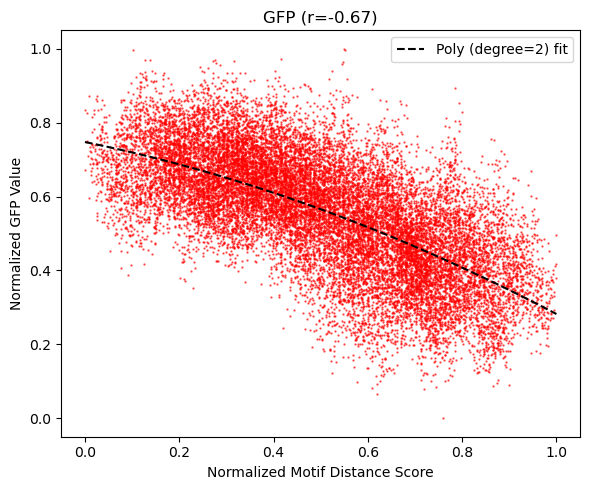

PWM for MA0152.1 has length: 7
PWM for MA1999.1 has length: 15
PWM for MA0039.1 has length: 10
PWM for MA0068.1 has length: 30
PWM1: [[0.115385, 0.038462, 0.076923, 0.769231], [0.038462, 0.076923, 0.076923, 0.807692], [0.038462, 0.038462, 0.0, 0.923077], [0.0, 0.0, 0.0, 1.0], [0.038462, 0.961538, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.692308, 0.115385, 0.038462, 0.153846]]
PWM2: [[0.178378, 0.489189, 0.128378, 0.204054], [0.141892, 0.218919, 0.239189, 0.4], [0.048649, 0.081081, 0.783784, 0.086486], [0.07973, 0.116216, 0.067568, 0.736486], [0.024324, 0.058108, 0.05, 0.867568], [0.027027, 0.914865, 0.017568, 0.040541], [0.052703, 0.041892, 0.027027, 0.878378], [0.021622, 0.914865, 0.040541, 0.022973], [0.02973, 0.925676, 0.024324, 0.02027], [0.777027, 0.109459, 0.054054, 0.059459], [0.024324, 0.07973, 0.172973, 0.722973], [0.058108, 0.7, 0.116216, 0.125676], [0.118919, 0.195946, 0.090541, 0.594595], [0.212162, 0.281081, 0.277027, 0.22973], [0.194595, 0.310811, 0.285135, 0.209459]]
PWM Count

KeyError: 0

In [9]:
# AC0069: 'MA0068.1'
# AC0065: 'MA0039.1'
# AC0072: 'MA0152.1'
# AC0073: 'MA1999.1'

plot_normalized_correlations_with_fit('/pmglocal/ty2514/Enhancer/Enhancer/train/Synthetic_Data_Generator/AC0073_AC0073.pkl', 'motif_distance_score',poly_order=2, subsample_fraction=0.3)

# Example usage:
csv_file_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/fragment_sequences.csv'
pwm1 = extract_pwm_from_meme(meme_file_dir, 'MA0152.1')
pwm2 = extract_pwm_from_meme(meme_file_dir, 'MA1999.1')
pwm3 = extract_pwm_from_meme(meme_file_dir, 'MA0039.1')
pwm4 = extract_pwm_from_meme(meme_file_dir, 'MA0068.1')
print("PWM1:", pwm1)
print("PWM2:", pwm2)
rank_sequences_by_motif_occurrences(csv_file_path, [pwm1,pwm2])

# Test Motif Frequency

In [43]:
import random
import pandas as pd
from itertools import product

# Assuming you already have the following helper functions:
# pwm_to_motif(extract_pwm_from_meme(input_dir, motif_name))
# generate_random_dna(dna_length)


def insert_motif_into_sequence(dna_sequence, motif, positions):
    """Insert the motif into the dna_sequence at the given positions."""
    for pos in positions:
        dna_sequence = dna_sequence[:pos] + motif + dna_sequence[pos+len(motif):]
    return dna_sequence

def generate_synthetic_distance_data(dna_length=200, motif_name=None, input_dir=None, output_dir=None, 
                                     max_num_motif=None, motif_distance=20, num_replicates=1, save_file=False):
    # Step 1: Get the motif sequence
    motif = pwm_to_motif(extract_pwm_from_meme(input_dir, motif_name))
    motif_length = len(motif)
    
    # Step 2: Validate max_num_motif
    max_possible_motif = (dna_length - motif_length) // (motif_distance + motif_length)
    if max_num_motif > max_possible_motif:
        raise ValueError(f"Too many motifs for the sequence length. Maximum allowed is {max_possible_motif}.")
    
    # Step 3: Initialize a list to store all results
    all_replicates_data = []
    
    # Step 4: Repeat the generation process for the number of replicates
    for replicate in range(1, num_replicates + 1):
        # Generate three random DNA sequences for each replicate
        dna_sequences = [generate_random_dna(dna_length) for _ in range(3)]
        
        # Create lists of sequences with 0, 1, ..., max_num_motif insertions for each sequence
        seg_lists = []
        for seg in dna_sequences:
            seg_list = []
            for num_motif in range(max_num_motif + 1):
                if num_motif == 0:
                    seg_list.append(seg)  # No motif insertion
                else:
                    # Calculate positions for inserting the motifs with given distance
                    positions = [i * (motif_distance + motif_length) for i in range(num_motif)]
                    seg_with_motif = insert_motif_into_sequence(seg, motif, positions)
                    seg_list.append(seg_with_motif)
            seg_lists.append(seg_list)
        
        # Generate all combinations of sequences from the three segments
        combined_sequences = []
        for comb in product(*seg_lists):
            combined_seq = comb[0] + 'CTGA' + comb[1] + 'ACCA' + comb[2]
            motif_count = sum([s.count(motif) for s in comb])
            combined_sequences.append({
                'sequence': combined_seq,
                'motif_freq_score': motif_count,
                'name': f'seg1_{comb[0].count(motif)}_seg2_{comb[1].count(motif)}_seg3_{comb[2].count(motif)}',
                'replicate': replicate  # Add the replicate number
            })
        
        # Add the results from this replicate to the main list
        all_replicates_data.extend(combined_sequences)
    
    # Step 5: Convert the combined data to a DataFrame
    result_df = pd.DataFrame(all_replicates_data)
    
    # Step 6: Optionally save the DataFrame to a pickle file
    if save_file:
        result_df.to_pickle(f"{output_dir}/combined_sequences_{num_replicates}_replicates.pkl")
    
    return result_df

# Example usage:
# generate_synthetic_distance_data(dna_length=200, motif_name='motif', input_dir='/path/to/input', output_dir='/path/to/output', max_num_motif=5, motif_distance=20, num_replicates=10, save_file=True)



In [51]:
weight_file = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN3_GFP_70NN_Rep3/best_r2_model_epoch_58.pth'
meme_file_dir = '/pmglocal/ty2514/Enhancer/motif-clustering/databases/jaspar2024/JASPAR2024_CORE_vertebrates_mus_musculus_non-redundant_pfms_meme.meme'
output_pickle_dir = '/pmglocal/ty2514/Enhancer/Enhancer/train/Synthetic_Data_Generator'
# AC0069: 'MA0068.1'
# AC0065: 'MA0039.1'
# AC0072: 'MA0152.1'
# AC0073: 'MA1999.1'

df = generate_synthetic_distance_data(dna_length = 200, motif_name = 'MA0152.1',input_dir = meme_file_dir,output_dir = output_pickle_dir,max_num_motif = 6, motif_distance = 25, num_replicates=50)
result_df = motif_score_prediction(model = explainn, df = df, device = device, batch = batch, target_labels=['GFP'],feature_list=['motif_freq_score'])

PWM for MA0152.1 has length: 7


In [54]:
result_df_without_sequence = result_df.drop(columns=['sequence'])
output = os.path.join('/pmglocal/ty2514/Enhancer/Enhancer/train/Synthetic_Data_Generator','AC0072_freq.csv')
result_df_without_sequence.to_csv(output, index=False)
#output = os.path.join('/pmglocal/ty2514/Enhancer/Enhancer/train/Synthetic_Data_Generator','AC0073_freq_pred.csv')
#df.to_csv(output, index=False)

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr

def plot_normalized_correlations_with_fit(csv_file_path, feature, poly_order=2):
    """
    This function takes the path to a CSV file, normalizes the 'motif_freq_score' or any
    other feature, and GFP column, calculates the correlation between them, and plots the 
    normalized scatter plot with a fitted line or curve.
    
    Args:
    - csv_file_path (str): Path to the CSV file containing the data.
    - feature (str): The feature to normalize and correlate (e.g., 'motif_freq_score').
    - poly_order (int): The order of the polynomial for curve fitting. Default is 2 (quadratic regression).
    
    Returns:
    - None
    """
    # Load the CSV file
    df = pd.read_csv(csv_file_path)

    # Check the column names to verify the existence of the desired feature
    print("Columns in DataFrame:", df.columns)

    # Drop 'sequence' column if it exists
    if 'sequence' in df.columns:
        df = df.drop(columns=['sequence'])

    # Group by 'name' to get the mean of GFP and the first value of the specified feature
    grouped_df = df.groupby('name').agg({
        feature: 'first',  # Take the first value of the specified feature (e.g., 'motif_freq_score')
        'GFP': 'mean'
    }).reset_index()

    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    # Normalize the specified feature to the range [0, 1]
    grouped_df[feature + '_normalized'] = scaler.fit_transform(grouped_df[[feature]])

    # Normalize GFP to the range [0, 1]
    grouped_df['GFP_normalized'] = scaler.fit_transform(grouped_df[['GFP']])

    # Calculate correlation between the normalized feature and normalized GFP values
    corr_gfp, _ = pearsonr(grouped_df[feature + '_normalized'], grouped_df['GFP_normalized'])

    # Print the correlation value
    print(f"Correlation between normalized {feature} and normalized GFP: {corr_gfp:.2f}")

    # Function to fit a line or curve
    def plot_with_fit(x, y, title, ax, color):
        # Scatter plot
        ax.scatter(x, y, color=color, alpha=0.6, s=3)
        
        # Fit a polynomial curve of degree `poly_order`
        poly_coeffs = np.polyfit(x, y, poly_order)
        poly_func = np.poly1d(poly_coeffs)
        
        # Plot the fitted line or curve
        x_vals = np.linspace(x.min(), x.max(), 100)
        y_vals = poly_func(x_vals)
        ax.plot(x_vals, y_vals, color=color, linestyle='--', label=f'Poly (degree={poly_order}) fit')
        
        # Add title and labels
        ax.set_title(title)
        ax.set_xlabel(f'Normalized {feature}')
        ax.set_ylabel('Normalized GFP Value')
        ax.legend()

    # Plot the scatter plot with fitted curve/line for GFP
    fig, ax = plt.subplots(figsize=(6, 5))

    # GFP
    plot_with_fit(grouped_df[feature + '_normalized'], grouped_df['GFP_normalized'],
                  f'GFP (r={corr_gfp:.2f})', ax, color='red')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the plot
    plt.show()


Columns in DataFrame: Index(['motif_freq_score', 'name', 'replicate', 'GFP'], dtype='object')
Correlation between normalized motif_freq_score and normalized GFP: -0.64


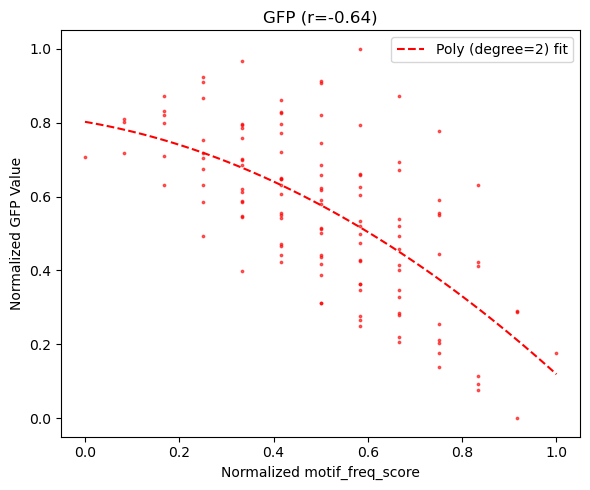

In [57]:
plot_normalized_correlations_with_fit('/pmglocal/ty2514/Enhancer/Enhancer/train/Synthetic_Data_Generator/AC0073_freq.csv', 'motif_freq_score')


# Test if model can predict motif distance or frequency score

In [61]:
batch = 322
num_cnns = 70
filter_size = 19
learning_rate = 5e-4
drop_out = 0.4
target_labels = ['motif_freq_score']


# Rep3
seed = 31
output_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN3_GFP_70NN_Synthetic_Distance'


print("Now reading the real data file")
df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/train/Synthetic_Data_Generator/AC0069_freq_pred.csv')

print("Success!")
print('')
print("Now splitting data and construct data loader")
train, test = split_dataset(df, split_type='random', cutoff = 0.8, seed = seed)

train = EnhancerDataset(train, feature_list=['motif_freq_score'], scale_mode = 'none')
test = EnhancerDataset(test, feature_list=['motif_freq_score'], scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=False)
print("Success!")
print('')
print("Now start training")

explainn_model = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 1, 
                 filter_size = filter_size, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = drop_out, weight_path = None)

# Check if more than one GPU is available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    explainn_model = nn.DataParallel(explainn_model)

_, _, explainn_model, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, explainn_device  = train_model(explainn_model, train_loader, test_loader, 
                                                                                                                            target_labels=target_labels,num_epochs=300, 
                                                                                                                        batch_size=batch, learning_rate=learning_rate, 
                                                                                                                        criteria='mse',optimizer_type = "adam", patience=10, 
                                                                                                                        seed = seed, save_model= True, dir_path=output_dir)


Now reading the real data file
Success!

Now splitting data and construct data loader
Success!

Now start training
Using device: cuda
Model is on device: cuda:0
Epoch 1/300, Step 1/32, Loss: 22.9437
Epoch 1/300: Train Loss: 20.2024 , Test Loss: 18.6128
------------------------Evaluation------------------------
Label 1: MSE=18.6122, RMSE=4.3142, MAE=4.1719, R^2=-3.9851, Pearson=0.9734, Spearman=0.9821
Overall (Flattened): MSE=18.6122, RMSE=4.3142, MAE=4.1719, R^2=-3.9851, Pearson=0.9734, Spearman=0.9821
----------------------------------------------------------
Epoch 2/300, Step 1/32, Loss: 16.7928
Epoch 2/300: Train Loss: 14.4951 , Test Loss: 11.2151
------------------------Evaluation------------------------
Label 1: MSE=11.2153, RMSE=3.3489, MAE=3.3067, R^2=-2.0039, Pearson=0.9641, Spearman=0.9846
Overall (Flattened): MSE=11.2153, RMSE=3.3489, MAE=3.3067, R^2=-2.0039, Pearson=0.9641, Spearman=0.9846
----------------------------------------------------------
Epoch 3/300, Step 1/32, Los

In [ ]:
import glob
file_list = glob.glob('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN3_GFP_70NN_Synthetic_Distance/best_pear*.pth')
if len(file_list) > 0:
    model_path = file_list[0]
else:
    raise FileExistsError("Best r2 Model file not exist")

mse, rmse, mae, r2, pearson_corr, spearman_corr = regression_model_plot(
    explainn_model, test_loader, train_losses_by_batch, test_losses_by_batch, 
    explainn_device, results, target_labels= target_labels, save_plot = False, dir_path = None, model_path = model_path)

print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}, Pearson Correlation: {pearson_corr:.4f}, Spearman Correlation: {spearman_corr:.4f}")

In [2]:
# AC0069: 'MA0068.1'
# AC0065: 'MA0039.1'
# AC0072: 'MA0152.1'
# AC0073: 'MA1999.1'

batch = 322
num_cnns = 70
filter_size = 19
learning_rate = 9e-4
drop_out = 0.4
target_labels = ['motif_distance_score']


# Rep3
seed = 31
output_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN3_GFP_70NN_Synthetic_Distance'


print("Now reading the real data file")
df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/train/Synthetic_Data_Generator/AC0072_AC0073_dist.csv')

print("Success!")
print('')
print("Now splitting data and construct data loader")
train, test = split_dataset(df, split_type='random', cutoff = 0.8, seed = seed)

train = EnhancerDataset(train, feature_list=['motif_distance_score'], scale_mode = 'none')
test = EnhancerDataset(test, feature_list=['motif_distance_score'], scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=False)
print("Success!")
print('')
print("Now start training")

explainn_model = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 1, 
                 filter_size = filter_size, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = drop_out, weight_path = None)

# Check if more than one GPU is available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    explainn_model = nn.DataParallel(explainn_model)

_, _, explainn_model, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, explainn_device  = train_model(explainn_model, train_loader, test_loader, 
                                                                                                                            target_labels=target_labels,num_epochs=300, 
                                                                                                                        batch_size=batch, learning_rate=learning_rate, 
                                                                                                                        criteria='mse',optimizer_type = "adam", patience=10, 
                                                                                                                        seed = seed, save_model= True, dir_path=output_dir)


Now reading the real data file
Success!

Now splitting data and construct data loader
Success!

Now start training
Using device: cuda
Model is on device: cuda:0
Epoch 1/300, Step 1/10, Loss: 106939.4297
Epoch 1/300: Train Loss: 101763.7266 , Test Loss: 107849.3229
------------------------Evaluation------------------------
Label 1: MSE=107216.0000, RMSE=327.4385, MAE=300.4081, R^2=-5.3014, Pearson=0.7646, Spearman=0.7099
Overall (Flattened): MSE=107216.0000, RMSE=327.4385, MAE=300.4081, R^2=-5.3014, Pearson=0.7646, Spearman=0.7099
----------------------------------------------------------
Epoch 2/300, Step 1/10, Loss: 92794.1328
Epoch 2/300: Train Loss: 102012.4133 , Test Loss: 107693.3177
------------------------Evaluation------------------------
Label 1: MSE=107063.4922, RMSE=327.2056, MAE=300.2542, R^2=-5.2924, Pearson=0.7635, Spearman=0.7074
Overall (Flattened): MSE=107063.4922, RMSE=327.2056, MAE=300.2542, R^2=-5.2924, Pearson=0.7635, Spearman=0.7074
-------------------------------

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

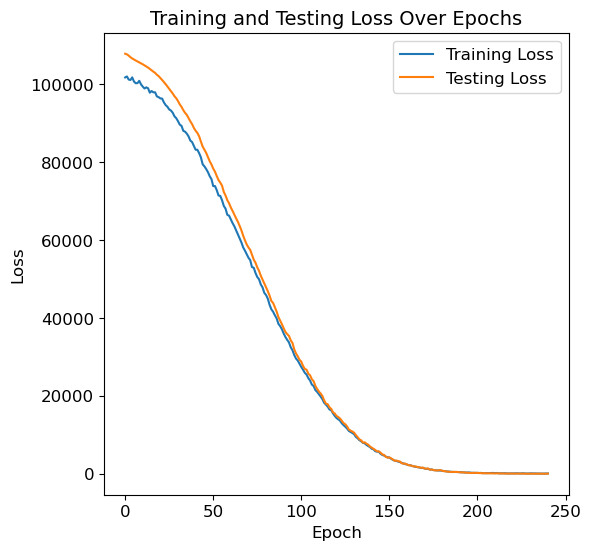

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

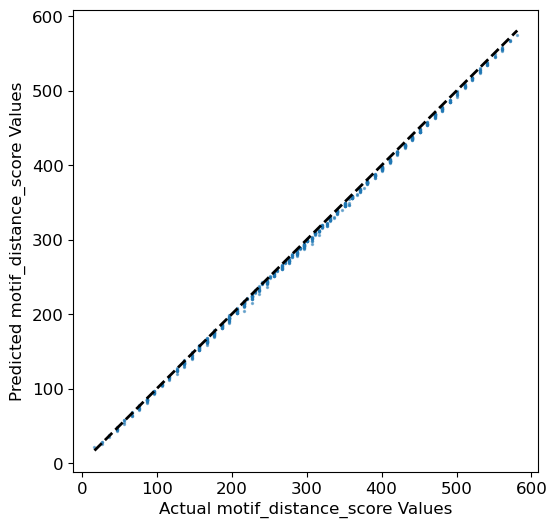

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

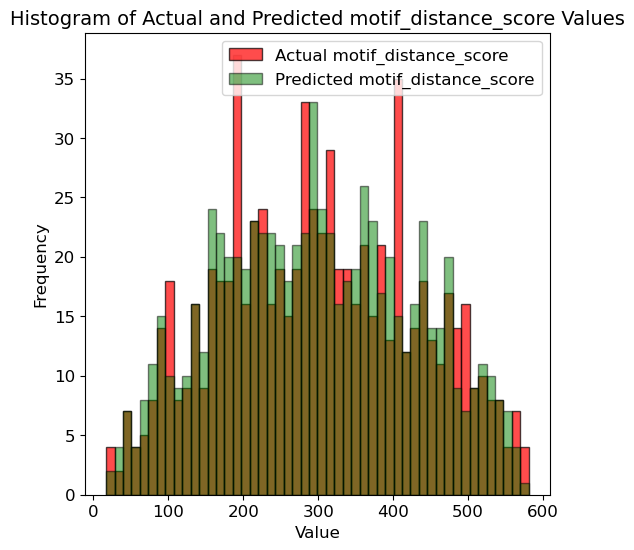

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

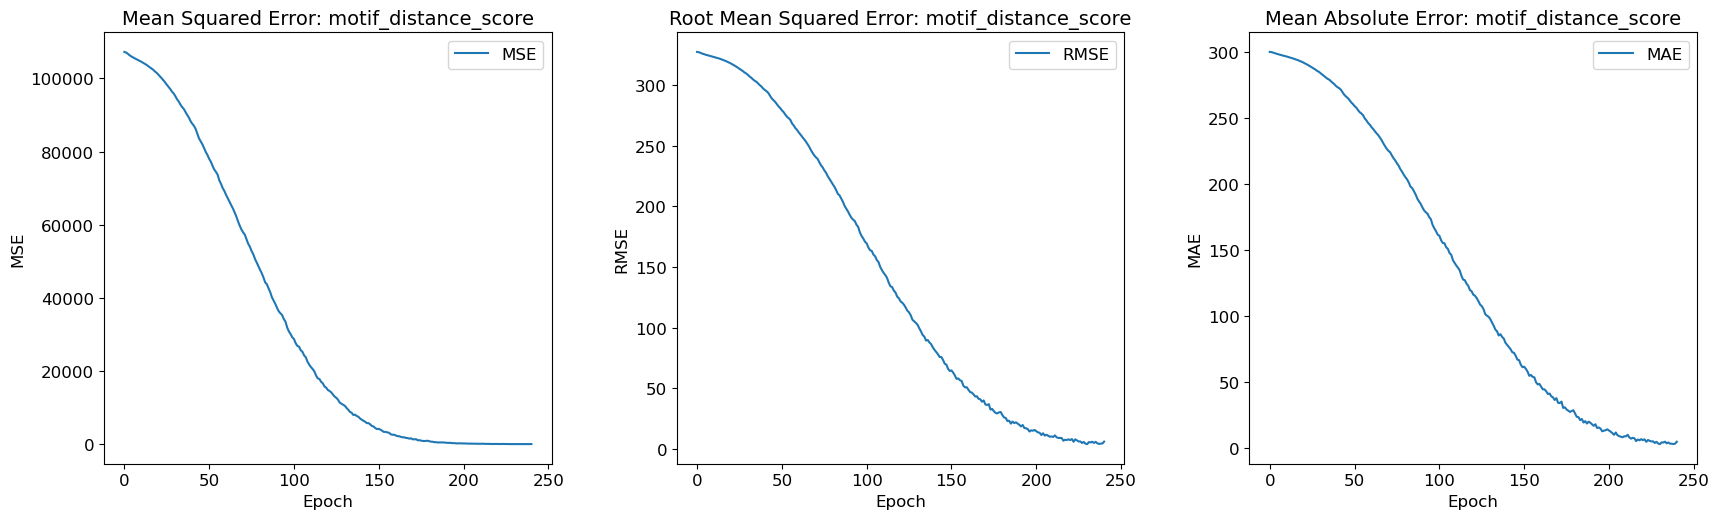

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

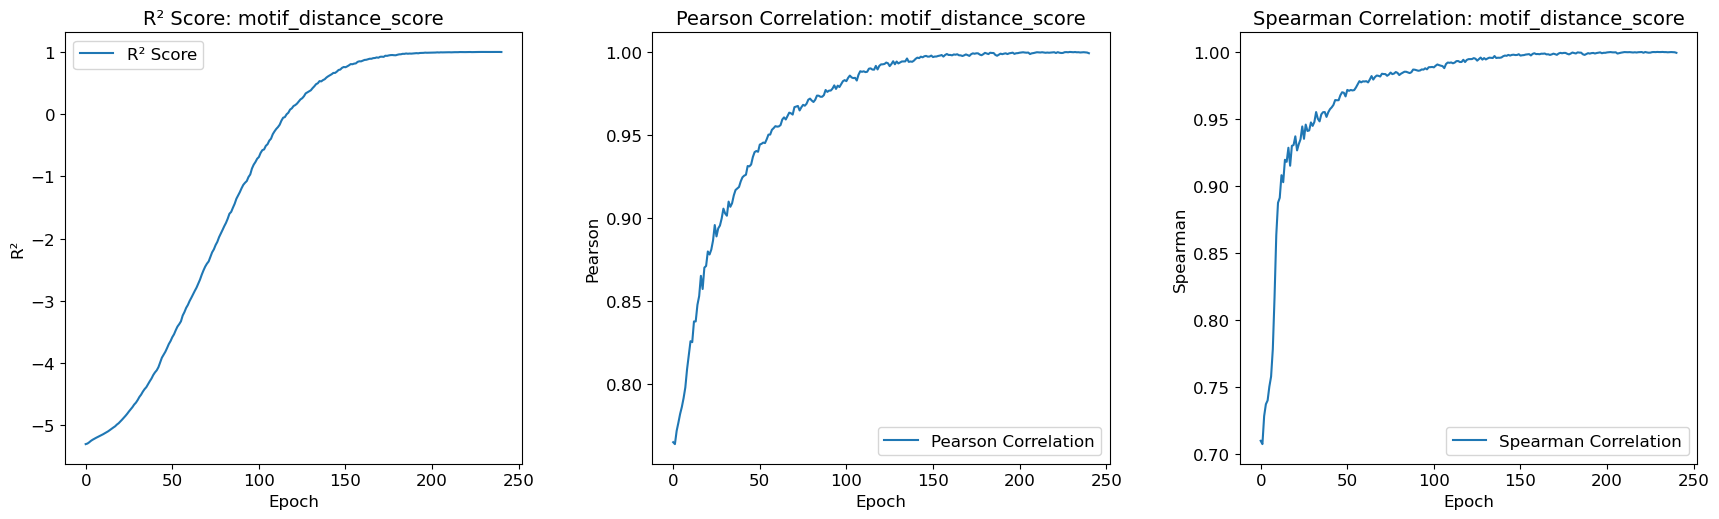

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

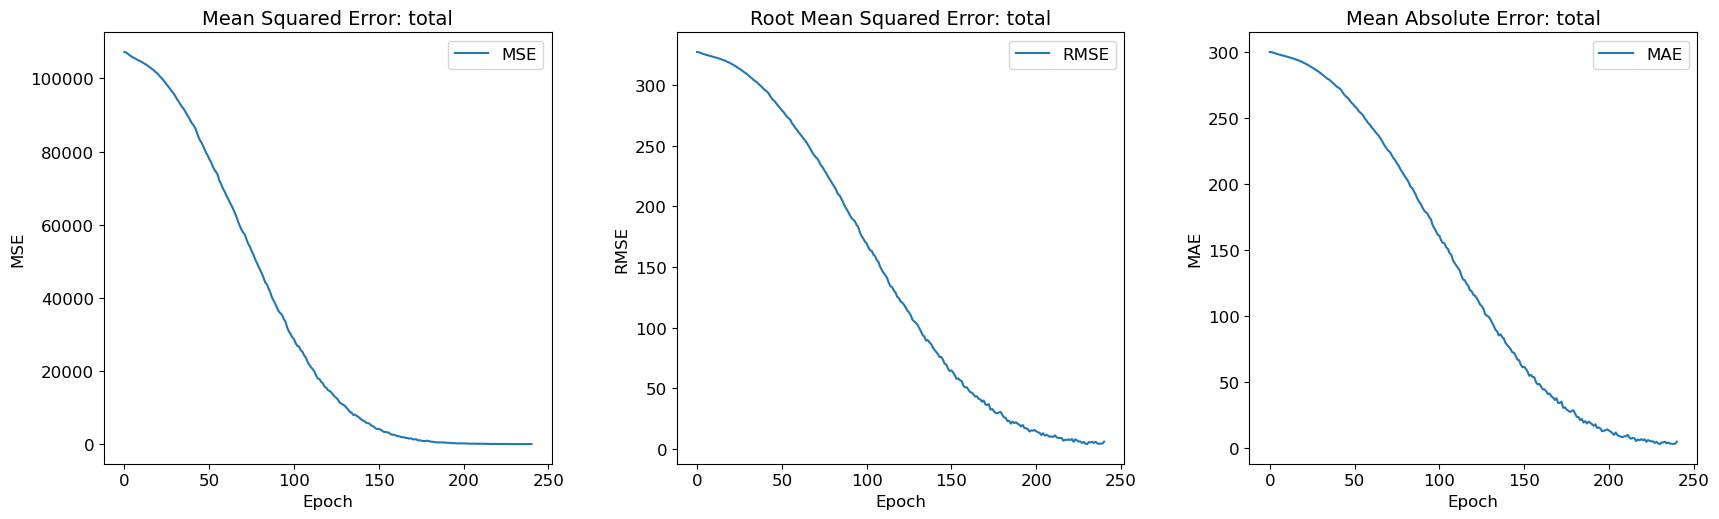

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

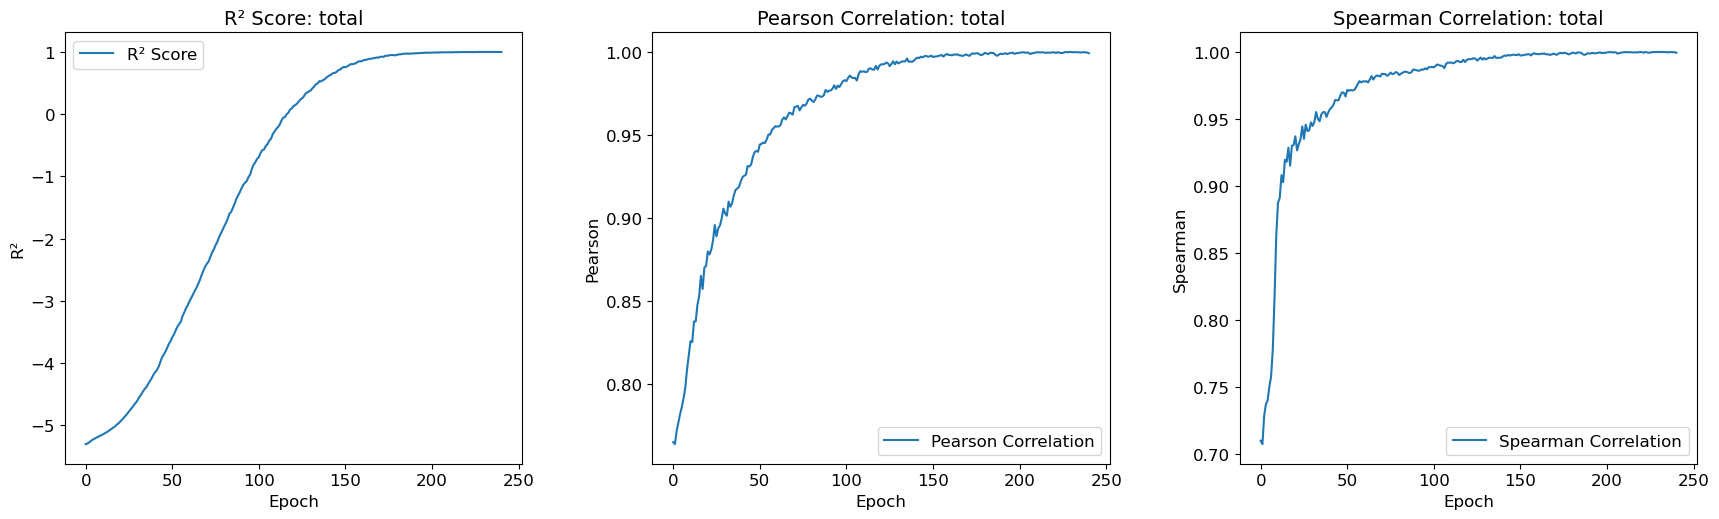

MSE: 36.1362, RMSE: 6.0113, MAE: 5.1121
R^2: 0.9979, Pearson Correlation: 0.9991, Spearman Correlation: 0.9991


In [3]:
import glob
file_list = glob.glob('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN3_GFP_70NN_Synthetic_Distance/best_pear*.pth')
if len(file_list) > 0:
    model_path = file_list[0]
else:
    raise FileExistsError("Best r2 Model file not exist")

mse, rmse, mae, r2, pearson_corr, spearman_corr = regression_model_plot(
    explainn_model, test_loader, train_losses_by_batch, test_losses_by_batch, 
    explainn_device, results, target_labels= target_labels, save_plot = False, dir_path = None, model_path = model_path)

print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}, Pearson Correlation: {pearson_corr:.4f}, Spearman Correlation: {spearman_corr:.4f}")